In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from typing import Tuple
from cvxopt import matrix, solvers
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

`cvxopt` 求解二次规划（Quadratic Programming）问题时，只认下面这种标准形式：

目标函数（求最小值）：
$$min_{x} \frac{1}{2}x^T P x + q^T x$$
限制条件：
$$Gx \le h$$

我们需要输入 `P` `q` `G` `h` 的值


### 1. 负责目标函数的 `P` 和 `q`：

- `P` (二次项矩阵)：形状是 $(n+1) \times (n+1)$ 的方阵。它要和变量向量 $x$ 进行两次乘法运算，所以长宽都必须是 $n+1$ 。除左上角第一个元素为 0 外，对角线其他元素为 1 。

- `q` (一次项向量)：形状是 $(n+1) \times 1$ 的列向量。因为我们的目标函数 $\frac{1}{2}||w||^2$ 里只有平方项，没有任何一次项（比如单独的 $w_1$ 或 $b$），所以 $q$ 里面全都是 0。



### 2. 负责限制条件的 `G` 和 `h`：

对于限制函数：

$$
\begin{align}
y_i(\omega \cdot x_i + b) &\ge 1 \\
y_{i} \cdot \omega \cdot x_{i} + y_{i} \cdot b &\geq 1 \\
- y_{i} \cdot b - y_{i} \cdot \omega \cdot x_{i}  &\leq -1
\end{align}
$$


- `G` (约束系数矩阵)：形状是 $m \times (n+1)$ ，第一个值对应 b ，填入 $- y_{i}$ 即可,后续的值对应 $\omega$，所以填入 -($y_{i} \cdot x_{i})$。

- `h` (约束常数向量)：形状是 $m \times 1$ 的列向量。它存放的是那 $m$ 条规矩不等号右边的具体数值，即全为 $-1$。

In [ ]:
class Hard_Margin_SVM:
    """实现线性可分支持向量机 (硬间隔最大化策略) [cite: 222, 223, 224]"""

    def __init__(self):
        self.w = None
        self.b = None

    def fit(self, X: np.ndarray, y: np.ndarray) -> Tuple[np.ndarray, float]:
        """线性可分支持向量机拟合方法，基于 cvxopt 求解二次规划问题 [cite: 225, 238, 251]

        Args:
            X (np.ndarray): 训练特征数据，形状为 (m, n)，m为样本数，n为特征数 [cite: 228]
            y (np.ndarray): 训练输出标签，形状为 (m,)，值为 1 或 -1 [cite: 195, 226]

        Returns:
            Tuple[np.ndarray, float]:
                - w: 权重向量，形状为 (n,) [cite: 241, 247]
                - b: 偏置项 (截距) [cite: 242, 247]
        """
        # 1. 获取训练样本数 m 和特征数 n
        m = X.shape[0]
        n = X.shape[1]
        # 2. 初始化二次规划相关变量: P, q, G, h (需转换为 cvxopt 的 matrix 格式)
        y_T = y.reshape(-1, 1)
        P = matrix(np.identity(n+1))
        P[0, 0] = 0
        q = matrix(np.zeros(n+1))
        G = matrix(np.hstack((-y_T, -y_T * X)))
        h = matrix(-np.ones(m))
        # 3. 构建并运行二次规划求解器 solvers.qp(P, q, G, h)
        sol = solvers.qp(P, q, G, h)
        # 4. 从求解结果 sol['x'] 中提取最优的 b 和 w 并赋给 self.b, self.w
        self.b = sol['x'][0]
        # 利用切片取从索引 1 开始的所有元素，并展平为一维的 numpy 数组
        self.w = np.ravel(sol['x'][1:])
        return self.w, self.b

    def predict(self, X: np.ndarray) -> np.ndarray:
        """定义模型预测函数 [cite: 248]

        Args:
            X (np.ndarray): 测试特征数据，形状为 (m_test, n) [cite: 249]

        Returns:
            np.ndarray: 预测标签，包含 1 或 -1
        """
        # 利用学习到的 self.w 和 self.b，计算线性映射值并返回其符号 (可使用 np.sign)
        result = self.w @ X.T + self.b
        return np.sign(result)

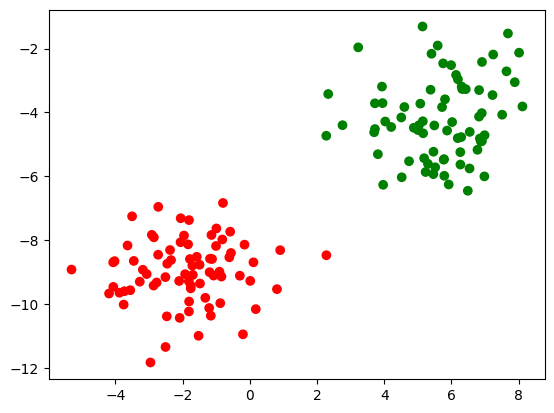

In [3]:
# 生成模拟二分类数据集
X, y =  make_blobs(n_samples=150, n_features=2, centers=2, cluster_std=1.2, random_state=40)
# 设置颜色参数
colors = {0:'r', 1:'g'}
# 绘制二分类数据集的散点图
plt.scatter(X[:,0], X[:,1], marker='o', c=pd.Series(y).map(colors))
plt.show()

In [4]:
# 将标签转换为1/-1
y_ = y.copy()
y_[y_==0] = -1
y_ = y_.astype(float)
X_train, X_test, y_train, y_test = train_test_split(X, y_, test_size=0.3, random_state=43)
print(f'X_train: {X_train.shape}\n' \
      f'y_train: {y_train.shape}\n' \
      f'X_test: {X_test.shape}\n' \
      f'y_test: {y_test.shape}')


X_train: (105, 2)
y_train: (105,)
X_test: (45, 2)
y_test: (45,)


In [5]:
HMV = Hard_Margin_SVM()
HMV.fit(X_train, y_train)

     pcost       dcost       gap    pres   dres
 0:  2.1061e-02  2.0725e+01  3e+02  2e+00  8e+02
 1:  1.7678e-01 -4.0311e+01  5e+01  3e-01  1e+02
 2:  2.5467e-01 -1.3854e+00  2e+00  1e-02  4e+00
 3:  2.1218e-01  4.0205e-02  2e-01  6e-04  2e-01
 4:  1.8309e-01  1.5738e-01  3e-02  8e-05  4e-02
 5:  1.8241e-01  1.8207e-01  3e-04  1e-06  4e-04
 6:  1.8239e-01  1.8239e-01  3e-06  1e-08  4e-06
 7:  1.8239e-01  1.8239e-01  3e-08  1e-10  4e-08
Optimal solution found.


(array([0.40882768, 0.44457681]), 1.8310613288769853)

In [6]:
y_pred = HMV.predict(X_test)
print(accuracy_score(y_test, y_pred))

1.0
